# Homework 2: Data from the Web

In [1]:
# Imports
import json
import difflib 
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from urllib.request import Request, urlopen

### Question 1
Obtain the 200 top-ranking universities in www.topuniversities.com (ranking 2018). In particular, extract the following fields for each university: name, rank, country and region, number of faculty members (international and total) and number of students (international and total). Some information is not available in the main list and you have to find them in the details page. Store the resulting dataset in a pandas DataFrame and answer the following questions:

### Explanation:

We use the given links to scrape the two websites: 1. QS Rankings 2. Times Higher Education (THE) Rankings. Once we get all the data in json format, we work with the top 200 universities only.

The columns we are concerned about are University, Rank, Country, Region, International Faculty, Total Faculty, International Students, and Total Students. The first four parameters are readily available in the json data. For the last four, we obtain the link from the json data and use Beautiful Soup to find the last four parameters after cleaning the fields.

e also added bar charts as asked, to compare the universities with their faculty-student ratio, international student ratio, and also grouped each university by the country and region it belonged to.

Finally, we also map all the countries to their respective regions and use this mapping for the data obtained from THE to add the regions field for those universities. The scraping for THE is similar to the ideas used for QS. This helped in grouping the ratios of universities by country and region.

In [3]:
# Constants required for data scraping
top_universities_url = 'https://www.topuniversities.com/sites/default/files/qs-rankings-data/357051_indicators.txt'
university_url = 'https://www.topuniversities.com'
number_of_top_universities = 200

# Load the data json file
hdr = {'User-Agent': 'Mozilla/5.0'}
request = Request(top_universities_url, headers=hdr)
page = urlopen(request)
data = json.loads(page.read().decode())

# Create an empty dataframe
cols = ['University',
        'Rank',
        'Country',
        'Region',
        'International Faculty',
        'Total Faculty',
        'International Students',
        'Total Students']
df = pd.DataFrame(columns=cols)

# Parse json for each of the top 200 ranked universities
for item in range(number_of_top_universities):
    # Obtain rank, country, region, and university name information
    rank = int(data['data'][item]['overall_rank'].strip('='))
    country = data['data'][item]['location']
    region = data['data'][item]['region']
    name = data['data'][item]['uni']
    soup = BeautifulSoup(name, "lxml")
    link = soup.find_all('a')[0]['href']
    name = soup.find_all('a')[0].text
    
    # Retrieve faculty and student data from the details page
    request = Request(university_url+link, headers=hdr)
    page = urlopen(request)
    soup = BeautifulSoup(page, "lxml")

    # Counts of the faculty, international faculty, total students, and international students
    faculty_total = 0
    inter_faculty_num = 0
    total_students_num = 0
    inter_students_num = 0

    # Constants used to clean the data
    empty_string = ''
    comma = ','
    separators = '\t\r\n '
    
    # Find faculty count if it exists and set to faculty_total
    faculty = soup.find('div', attrs={'class':'total faculty'})
    if faculty:
        faculty_total = (faculty.find('div', attrs={'class':'number'}).text).strip(separators)
        faculty_total = int(faculty_total.replace(comma, empty_string))

    # Find international faculty count if it exists and set to inter_faculty_num 
    inter_faculty = soup.find('div', attrs={'class':'inter faculty'})
    if inter_faculty:
        inter_faculty_num = (inter_faculty.find('div', attrs={'class':'number'}).text).replace(separators, empty_string)
        inter_faculty_num = int(inter_faculty_num.replace(comma, empty_string))

    # Find total students count if it exists and set to total_students_num
    total_students = soup.find('div', attrs={'class':'total student'})
    if total_students:
        total_students_num = (total_students.find('div', attrs={'class':'number'}).text).replace(separators, empty_string)
        total_students_num = int(total_students_num.replace(comma, empty_string))

    # Find international students count if it exists and set to inter_students_num
    inter_students = soup.find('div', attrs={'class':'total inter'})
    if inter_students:
        inter_students_num = (inter_students.find('div', attrs={'class':'number'}).text).replace(separators, empty_string)
        inter_students_num = int(inter_students_num.replace(comma, empty_string))

    # Append each row of the data to the dataframe
    df2 = pd.DataFrame([[name, rank, country, region, inter_faculty_num, faculty_total, inter_students_num, total_students_num]], columns=cols)
    df = df.append(df2, ignore_index=True)

# Create a copy of the dataframe for question 3
t1 = df.copy()

# Display the first few rows below
df.head(n=15)

,University,Rank,Country,Region,International Faculty,Total Faculty,International Students,Total Students
0,Massachusetts Institute of Technology (MIT),1,United States,North America,1679,2982,3717,11067
1,Stanford University,2,United States,North America,2042,4285,3611,15878
2,Harvard University,3,United States,North America,1311,4350,5266,22429
3,California Institute of Technology (Caltech),4,United States,North America,350,953,647,2255
4,University of Cambridge,5,United Kingdom,Europe,2278,5490,6699,18770
5,University of Oxford,6,United Kingdom,Europe,2964,6750,7353,19720
6,UCL (University College London),7,United Kingdom,Europe,2554,6345,14854,31080
7,Imperial College London,8,United Kingdom,Europe,2071,3930,8746,16090
8,University of Chicago,9,United States,North America,635,2449,3379,13557
9,ETH Zurich - Swiss Federal Institute of Techno...,10,Switzerland,Europe,1886,2477,7563,19815


In [4]:
# Map country to region for question 2
map_country_region = {t1['Country'][k]: t1['Region'][k] for k in range(200)}

# Handle exceptions
map_country_region['Luxembourg'] = 'Europe'
map_country_region['Russian Federation'] = 'Europe'

## Hint: Plot your data below using bar charts and describe briefly what you observed. Assume 'best universities' to refer to a top-k. Here our k = 10.

#### (a) Which are the best universities in terms of ratio between faculty members and students?

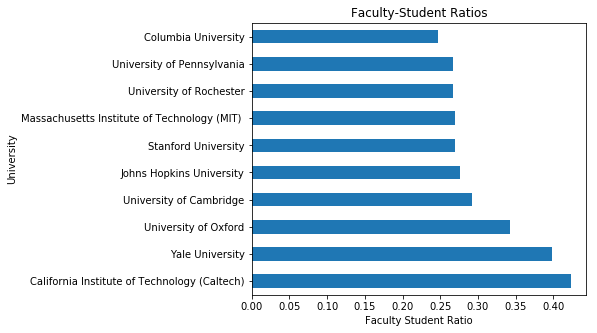

In [5]:
# Replace all zero's with NaN values so ratio calculations can be made
t1 = t1.replace(0, np.NaN)
ratios_qs = t1.copy()

# Calculate the ratio of total faculty to total students
ratios_qs['Faculty-Student Ratio'] = ratios_qs['Total Faculty']/ratios_qs['Total Students']

# Sort the ratios by ascending order (ascending is False because the higher the ratio, the higher the ranking should be)
fs_ratios = ratios_qs.sort_values('Faculty-Student Ratio', ascending=False)
top_10_fs_ratios = fs_ratios[['University', 'Faculty-Student Ratio']].head(n=10)

# Plot the ratios on a bar chart
ax = top_10_fs_ratios.plot(x='University', y='Faculty-Student Ratio', kind='barh', figsize=(6,5), title='Faculty-Student Ratios', legend=False)
ax.set_xlabel('Faculty Student Ratio')
plt.show()

### Result:

The top 10 universities in terms of faculty-student ratio are:

In [6]:
top_10_fs_ratios

,University,Faculty-Student Ratio
3,California Institute of Technology (Caltech),0.422616
15,Yale University,0.398323
5,University of Oxford,0.342292
4,University of Cambridge,0.292488
16,Johns Hopkins University,0.276353
1,Stanford University,0.269870
0,Massachusetts Institute of Technology (MIT),0.269450
185,University of Rochester,0.266604
18,University of Pennsylvania,0.266437
17,Columbia University,0.247115


#### (b) Which are the best universities in terms of ratio of international students?

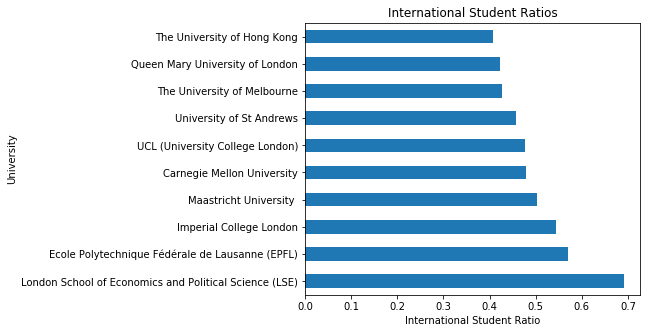

In [7]:
# Calculate the ratio of international students to total students
ratios_qs['International Student Ratio'] = ratios_qs['International Students']/ratios_qs['Total Students']

# Sort the ratios by ascending order
inter_ratio = ratios_qs.sort_values('International Student Ratio', ascending=False)
top_10_inter_ratio = inter_ratio[['University', 'International Student Ratio']].head(n=10)

# Plot the ratios on a bar chart
ax = top_10_inter_ratio.plot(x='University', y='International Student Ratio', kind='barh', figsize=(6,5), title='International Student Ratios', legend=False)
ax.set_xlabel('International Student Ratio')
plt.show()

### Result:

The top 10 universities in terms of international student ratio are:

In [8]:
top_10_inter_ratio

,University,International Student Ratio
34,London School of Economics and Political Scien...,0.691393
11,Ecole Polytechnique Fédérale de Lausanne (EPFL),0.570047
7,Imperial College London,0.543567
199,Maastricht University,0.502533
46,Carnegie Mellon University,0.478062
6,UCL (University College London),0.477928
91,University of St Andrews,0.457955
41,The University of Melbourne,0.427434
126,Queen Mary University of London,0.421816
25,The University of Hong Kong,0.407144


#### (c) Aggregate answers (a) and (b) by country

In [9]:
fs_ratios_country = fs_ratios[['University', 'Country', 'Faculty-Student Ratio']].head(n=10)

# Aggregate faculty-student ratios by country and university
fs_ratios_country = fs_ratios_country.set_index(['Country', 'University'])
fs_ratios_country = fs_ratios_country.sort_index()

inter_ratios_country = inter_ratio[['University', 'Country', 'International Student Ratio']].head(n=10)

# Aggregate international student ratios by country and university
inter_ratios_country = inter_ratios_country.set_index(['Country', 'University'])
inter_ratios_country = inter_ratios_country.sort_index()

### Result:

The top 10 universities for faculty-student ratio agreggated by country are:

In [10]:
fs_ratios_country

Faculty-Student Ratio
Country        University                                                         
United Kingdom University of Cambridge                                    0.292488
               University of Oxford                                       0.342292
United States  California Institute of Technology (Caltech)               0.422616
               Columbia University                                        0.247115
               Johns Hopkins University                                   0.276353
               Massachusetts Institute of Technology (MIT)                0.269450
               Stanford University                                        0.269870
               University of Pennsylvania                                 0.266437
               University of Rochester                                    0.266604
               Yale University                                            0.398323

### Result:

The top 10 universities for international student ratio agreggated by country are:

In [11]:
inter_ratios_country

International Student Ratio
Country        University                                                                     
Australia      The University of Melbourne                                            0.427434
Hong Kong      The University of Hong Kong                                            0.407144
Netherlands    Maastricht University                                                  0.502533
Switzerland    Ecole Polytechnique Fédérale de Lausanne (EPFL)                        0.570047
United Kingdom Imperial College London                                                0.543567
               London School of Economics and Political Scienc...                     0.691393
               Queen Mary University of London                                        0.421816
               UCL (University College London)                                        0.477928
               University of St Andrews                                               0.457955
United States  Carnegie Mellon University                                             0.478062

#### (d) Aggregate answers (a) and (b) by region

In [12]:
fs_ratios_region = fs_ratios[['University', 'Region', 'Faculty-Student Ratio']].head(n=10)

# Aggregate faculty-student ratios by region and university
fs_ratios_region = fs_ratios_region.set_index(['Region', 'University'])
fs_ratios_region = fs_ratios_region.sort_index()

inter_ratios_region = inter_ratio[['University', 'Region', 'International Student Ratio']].head(n=10)

# Aggregate international student ratios by region and university
inter_ratios_region = inter_ratios_region.set_index(['Region', 'University'])
inter_ratios_region = inter_ratios_region.sort_index()

### Result:

The top 10 universities for faculty-student ratio agreggated by region are:

In [13]:
fs_ratios_region

Faculty-Student Ratio
Region        University                                                         
Europe        University of Cambridge                                    0.292488
              University of Oxford                                       0.342292
North America California Institute of Technology (Caltech)               0.422616
              Columbia University                                        0.247115
              Johns Hopkins University                                   0.276353
              Massachusetts Institute of Technology (MIT)                0.269450
              Stanford University                                        0.269870
              University of Pennsylvania                                 0.266437
              University of Rochester                                    0.266604
              Yale University                                            0.398323

### Result:

The top 10 universities for international student ratio agreggated by region are:

In [14]:
inter_ratios_region

International Student Ratio
Region        University                                                                     
Asia          The University of Hong Kong                                            0.407144
Europe        Ecole Polytechnique Fédérale de Lausanne (EPFL)                        0.570047
              Imperial College London                                                0.543567
              London School of Economics and Political Scienc...                     0.691393
              Maastricht University                                                  0.502533
              Queen Mary University of London                                        0.421816
              UCL (University College London)                                        0.477928
              University of St Andrews                                               0.457955
North America Carnegie Mellon University                                             0.478062
Oceania       The University of Melbourne                                            0.427434

### Question 2
Obtain the 200 top-ranking universities in www.timeshighereducation.com (ranking 2018). Repeat the analysis of the previous point and discuss briefly what you observed.

In [15]:
# Load the data json file
top_universities_url = 'https://www.timeshighereducation.com/sites/default/files/the_data_rankings/world_university_rankings_2018_limit0_369a9045a203e176392b9fb8f8c1cb2a.json'

hdr = {'User-Agent': 'Mozilla/5.0'}
request = Request(top_universities_url, headers=hdr)
page = urlopen(request)
data = json.loads(page.read().decode())['data']

# Create an empty dataframe
cols = ['University',
        'Rank',
        'Country',
        'Region',
        'Faculty-Student Ratio',
        'International Student Ratio']
df = pd.DataFrame(columns=cols)

# Parse json for each ranking
for item in range(number_of_top_universities):
    # Obtain university name, rank, country, student-staff ratio, and international student percent
    name = data[item]['name']
    rank = int(data[item]['rank'].strip('='))
    country = data[item]['location']
    stud_staff_ratio = 1/float(data[item]['stats_student_staff_ratio'])
    inter_stud_percent = int(data[item]['stats_pc_intl_students'].strip('%'))/100
    
    # Append each row of data to the dataframe
    df2 = pd.DataFrame([[name, rank, country, map_country_region[country], stud_staff_ratio, inter_stud_percent]], columns=cols)
    df = df.append(df2, ignore_index=True)
    
# Create a copy of the dataframe for question 3
t2 = df.copy()

# Display the first few rows below
df.head(n=10)

,University,Rank,Country,Region,Faculty-Student Ratio,International Student Ratio
0,University of Oxford,1,United Kingdom,Europe,0.089286,0.38
1,University of Cambridge,2,United Kingdom,Europe,0.091743,0.35
2,California Institute of Technology,3,United States,North America,0.153846,0.27
3,Stanford University,3,United States,North America,0.133333,0.22
4,Massachusetts Institute of Technology,5,United States,North America,0.114943,0.34
5,Harvard University,6,United States,North America,0.112360,0.26
6,Princeton University,7,United States,North America,0.120482,0.24
7,Imperial College London,8,United Kingdom,Europe,0.087719,0.55
8,University of Chicago,9,United States,North America,0.161290,0.25
9,ETH Zurich – Swiss Federal Institute of Techno...,10,Switzerland,Europe,0.068493,0.38


#### (a) Which are the best universities in terms of ratio between faculty members and students?

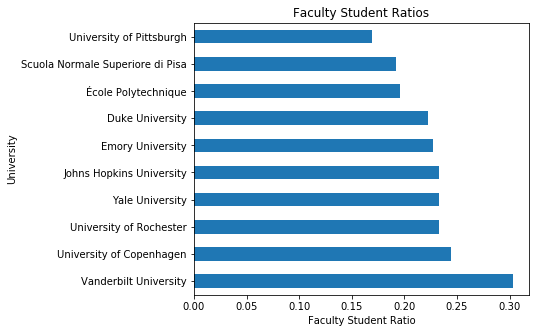

In [16]:
# Replace all zero's with NaN values so ratio calculations can be made
t2 = t2.replace(0, np.NaN)
ratios_THE = t2.copy()

# Sort the faculty-student ratios by ascending order
fs_ratios = ratios_THE.sort_values('Faculty-Student Ratio', ascending=False)
top_10_fs_ratios = fs_ratios[['University', 'Faculty-Student Ratio']].head(n=10)

# Plot the ratios on a bar chart
ax = top_10_fs_ratios.plot(x='University', y='Faculty-Student Ratio', kind='barh', figsize=(6,5), title='Faculty Student Ratios', legend=False)
ax.set_xlabel('Faculty Student Ratio')
plt.show()

### Result:

The top 10 universities in terms of faculty-student ratio are:

In [17]:
top_10_fs_ratios

,University,Faculty-Student Ratio
105,Vanderbilt University,0.303030
109,University of Copenhagen,0.243902
153,University of Rochester,0.232558
11,Yale University,0.232558
12,Johns Hopkins University,0.232558
97,Emory University,0.227273
16,Duke University,0.222222
114,École Polytechnique,0.196078
183,Scuola Normale Superiore di Pisa,0.192308
101,University of Pittsburgh,0.169492


#### (b) Which are the best universities in terms of ratio of international students?

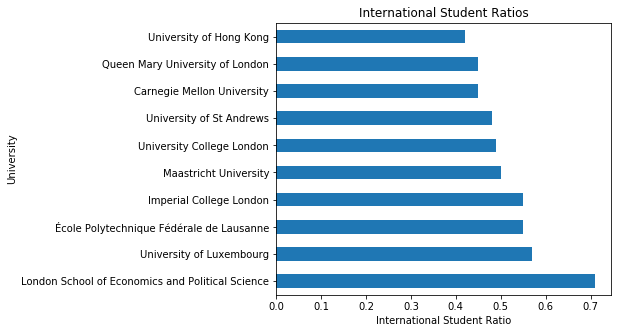

In [18]:
# Sort the international student ratios by ascending order
inter_ratio = ratios_THE.sort_values('International Student Ratio', ascending=False)
top_10_inter_ratio = inter_ratio[['University', 'International Student Ratio']].head(n=10)

# Plot the ratios on a bar chart
ax = top_10_inter_ratio.plot(x='University', y='International Student Ratio', kind='barh', figsize=(6,5), title='International Student Ratios', legend=False)
ax.set_xlabel('International Student Ratio')
plt.show()

### Result:

The top 10 universities in terms of international student ratio are:

In [19]:
top_10_inter_ratio

,University,International Student Ratio
24,London School of Economics and Political Science,0.71
178,University of Luxembourg,0.57
37,École Polytechnique Fédérale de Lausanne,0.55
7,Imperial College London,0.55
102,Maastricht University,0.50
15,University College London,0.49
143,University of St Andrews,0.48
23,Carnegie Mellon University,0.45
120,Queen Mary University of London,0.45
39,University of Hong Kong,0.42


#### (c) Aggregate answers (a) and (b) by country

In [20]:
fs_ratios_country = fs_ratios[['University', 'Country', 'Faculty-Student Ratio']].head(n=10)

# Aggregate faculty-student ratios by country and university
fs_ratios_country = fs_ratios_country.set_index(['Country', 'University'])
fs_ratios_country = fs_ratios_country.sort_index()

inter_ratios_country = inter_ratio[['University', 'Country', 'International Student Ratio']].head(n=10)

# Aggregate international student ratios by country and university
inter_ratios_country = inter_ratios_country.set_index(['Country', 'University'])
inter_ratios_country = inter_ratios_country.sort_index()

### Result:

The top 10 universities for faculty-student ratio agreggated by country are:

In [21]:
fs_ratios_country

Faculty-Student Ratio
Country       University                                             
Denmark       University of Copenhagen                       0.243902
France        École Polytechnique                            0.196078
Italy         Scuola Normale Superiore di Pisa               0.192308
United States Duke University                                0.222222
              Emory University                               0.227273
              Johns Hopkins University                       0.232558
              University of Pittsburgh                       0.169492
              University of Rochester                        0.232558
              Vanderbilt University                          0.303030
              Yale University                                0.232558

The top 10 universities for international student ratio agreggated by country are:

In [22]:
inter_ratios_country

International Student Ratio
Country        University                                                                   
Hong Kong      University of Hong Kong                                                  0.42
Luxembourg     University of Luxembourg                                                 0.57
Netherlands    Maastricht University                                                    0.50
Switzerland    École Polytechnique Fédérale de Lausanne                                 0.55
United Kingdom Imperial College London                                                  0.55
               London School of Economics and Political Science                         0.71
               Queen Mary University of London                                          0.45
               University College London                                                0.49
               University of St Andrews                                                 0.48
United States  Carnegie Mellon University                                               0.45

#### (d) Aggregate answers (a) and (b) by region

In [23]:
fs_ratios_region = fs_ratios[['University', 'Region', 'Faculty-Student Ratio']].head(n=10)

# Aggregate faculty-student ratios by region and university
fs_ratios_region = fs_ratios_region.set_index(['Region', 'University'])
fs_ratios_region = fs_ratios_region.sort_index()

inter_ratios_region = inter_ratio[['University', 'Region', 'International Student Ratio']].head(n=10)

# Aggregate international student ratios by region and university
inter_ratios_region = inter_ratios_region.set_index(['Region', 'University'])
inter_ratios_region = inter_ratios_region.sort_index()

The top 10 universities for faculty-student ratio agreggated by region are:

In [24]:
fs_ratios_region

Faculty-Student Ratio
Region        University                                             
Europe        Scuola Normale Superiore di Pisa               0.192308
              University of Copenhagen                       0.243902
              École Polytechnique                            0.196078
North America Duke University                                0.222222
              Emory University                               0.227273
              Johns Hopkins University                       0.232558
              University of Pittsburgh                       0.169492
              University of Rochester                        0.232558
              Vanderbilt University                          0.303030
              Yale University                                0.232558

The top 10 universities for international student ratio agreggated by region are:

In [25]:
inter_ratios_region

International Student Ratio
Region        University                                                                   
Asia          University of Hong Kong                                                  0.42
Europe        Imperial College London                                                  0.55
              London School of Economics and Political Science                         0.71
              Maastricht University                                                    0.50
              Queen Mary University of London                                          0.45
              University College London                                                0.49
              University of Luxembourg                                                 0.57
              University of St Andrews                                                 0.48
              École Polytechnique Fédérale de Lausanne                                 0.55
North America Carnegie Mellon University                                               0.45

## Question 3

#### Merge the two DataFrames created in questions 1 and 2 using university names. Match universities' names as well as you can, and explain your strategy. Keep track of the original position in both rankings.

Our strategy is to create an index on univerity names and perform an approximated matching to homogenize the university names. We conduct the matching using the [difflib.get_close_matches](https://docs.python.org/2/library/difflib.html) functionality which finds the best matches of a value from a list. In this case, the university name in Table 1 is matched from a list of close values of university names from Table 2. Then an outer join is performed. 

    The function difflib.get_close_matches works as following
 
    Input data: difflib.get_close_matches(word, possibilities[, n][, cutoff])

    Optional argument n (default 3) is the maximum number of close matches to return; n must be greater than 0.

    Optional argument cutoff (default 0.6) is a float in the range [0, 1]. Possibilities that don’t score at least that similar to word are ignored.

    The best (no more than n) matches among the possibilities are returned in a list, sorted by similarity score, most similar first.

In [26]:
# Homogenize columns names and rename them 
TM1 = ratios_qs.copy()
TM2 = ratios_THE.copy()
TM1.drop(['International Faculty',
          'Total Faculty',
          'International Students',
          'Total Students'],
         axis=1,
         inplace=True)

# Rename the rank columns for each dataset accordingly
# TM1 represents QS rankings and TM2 represents THE rankings
TM1 = TM1.rename(columns={
                    'Rank':'Rank_QS',
                    'Faculty-Student Ratio':'Faculty-Student Ratio_QS',
                    'International Student Ratio':'International Student Ratio_QS'
                    })
TM2 = TM2.rename(columns={
                    'Rank':'Rank_THE',
                    'Faculty-Student Ratio':'Faculty-Student Ratio_THE',
                    'International Student Ratio':'International Student Ratio_THE'
                    })

In [27]:
TM1.head()

,University,Rank_QS,Country,Region,Faculty-Student Ratio_QS,International Student Ratio_QS
0,Massachusetts Institute of Technology (MIT),1,United States,North America,0.269450,0.335863
1,Stanford University,2,United States,North America,0.269870,0.227422
2,Harvard University,3,United States,North America,0.193945,0.234785
3,California Institute of Technology (Caltech),4,United States,North America,0.422616,0.286918
4,University of Cambridge,5,United Kingdom,Europe,0.292488,0.356899


In [28]:
TM2.head()

,University,Rank_THE,Country,Region,Faculty-Student Ratio_THE,International Student Ratio_THE
0,University of Oxford,1,United Kingdom,Europe,0.089286,0.38
1,University of Cambridge,2,United Kingdom,Europe,0.091743,0.35
2,California Institute of Technology,3,United States,North America,0.153846,0.27
3,Stanford University,3,United States,North America,0.133333,0.22
4,Massachusetts Institute of Technology,5,United States,North America,0.114943,0.34


In [29]:
# Get closest match on university name in both tables
TM2.index = TM2['University']
TM1['University'] = TM1['University'].map(lambda x:
                                          (difflib.get_close_matches(x, TM2.index)[:1] or [None])[0])

# Perform an outer merge on the tables
merged_df = pd.merge(TM1, TM2, how='outer')

In [30]:
merged_df.head(n=7)

,University,Rank_QS,Country,Region,Faculty-Student Ratio_QS,International Student Ratio_QS,Rank_THE,Faculty-Student Ratio_THE,International Student Ratio_THE
0,Massachusetts Institute of Technology,1.0,United States,North America,0.269450,0.335863,5.0,0.114943,0.34
1,Stanford University,2.0,United States,North America,0.269870,0.227422,3.0,0.133333,0.22
2,Harvard University,3.0,United States,North America,0.193945,0.234785,6.0,0.112360,0.26
3,California Institute of Technology,4.0,United States,North America,0.422616,0.286918,3.0,0.153846,0.27
4,University of Cambridge,5.0,United Kingdom,Europe,0.292488,0.356899,2.0,0.091743,0.35
5,University of Oxford,6.0,United Kingdom,Europe,0.342292,0.372870,1.0,0.089286,0.38
6,University College London,7.0,United Kingdom,Europe,0.204151,0.477928,16.0,0.095238,0.49


## Question 4
#### Find useful insights in the data by performing an exploratory analysis. Can you find a strong correlation between any pair of variables in the dataset you just created? Example: when a university is strong in its international dimension, can you observe a consistency both for students and faculty members?

First, we get an initial idea of the potential correlations in the dataset 

In [31]:
# Get rid of any potential NaN in the data frame 
merged_df.head()
merged_df.dropna(axis=0, how='any', inplace=True)

In [32]:
# Print the correlations between the columns of the dataframe
results = merged_df.corr()
results

,Rank_QS,Faculty-Student Ratio_QS,International Student Ratio_QS,Rank_THE,Faculty-Student Ratio_THE,International Student Ratio_THE
Rank_QS,1.000000,-0.421678,-0.337036,0.671308,-0.220418,-0.313661
Faculty-Student Ratio_QS,-0.421678,1.000000,0.123154,-0.345898,0.692484,0.140600
International Student Ratio_QS,-0.337036,0.123154,1.000000,-0.229585,-0.072462,0.953898
Rank_THE,0.671308,-0.345898,-0.229585,1.000000,-0.129673,-0.215607
Faculty-Student Ratio_THE,-0.220418,0.692484,-0.072462,-0.129673,1.000000,-0.042680
International Student Ratio_THE,-0.313661,0.140600,0.953898,-0.215607,-0.042680,1.000000


Then we look at correlations of similar variables across rankings 

In [33]:
similar_variables = [{
    'Rank QS vs THE': results.iloc[3, 0],
    'Faculty-Student Ratio QS vs THE': results.iloc[4, 1],
    'International Student Ratio QS vs THE': results.iloc[5, 2]}]
df_similar = pd.DataFrame(similar_variables)
df_similar

,Faculty-Student Ratio QS vs THE,International Student Ratio QS vs THE,Rank QS vs THE
0,0.692484,0.953898,0.671308


We can see that the ranks from both websites are fairly positively correlated. The reason behind a perfect correlation is that the two websites and organizations use other metrics as well and with different co-efficients. For example, QS uses employer reputation whereas THE uses industry income. These metrics can vary a lot based on the data received and the percentage of students going into engineering or business fields as compared to graduate school or humanities fields.

The ratio scores Faculty-Student and International Student are respectively moderately and highly correlated. This is consistent with what we expect. Again, the difference is based on the data received and at what period it was received and put into account on the website.

Now, let's have a look at the correlations within each ranking. 

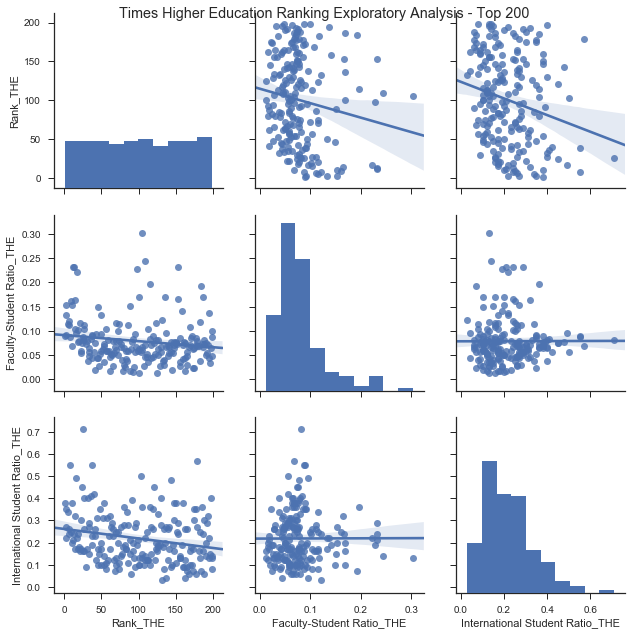

,Rank_THE,Faculty-Student Ratio_THE,International Student Ratio_THE
Rank_THE,1.000000,-0.152612,-0.214197
Faculty-Student Ratio_THE,-0.152612,1.000000,0.002730
International Student Ratio_THE,-0.214197,0.002730,1.000000


In [34]:
# Represent the THE (Times Higher Education) data with scatter plots 
# TM1 represents QS rankings and TM2 represents THE rankings
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

sns.set(style="ticks")

sns.pairplot(TM2, size=3, kind="reg")
sns.plt.suptitle('Times Higher Education Ranking Exploratory Analysis - Top 200')

plt.show()
TM2.corr()

Here no strong correlation is found between the variables of Times Higher Education Ranking. 

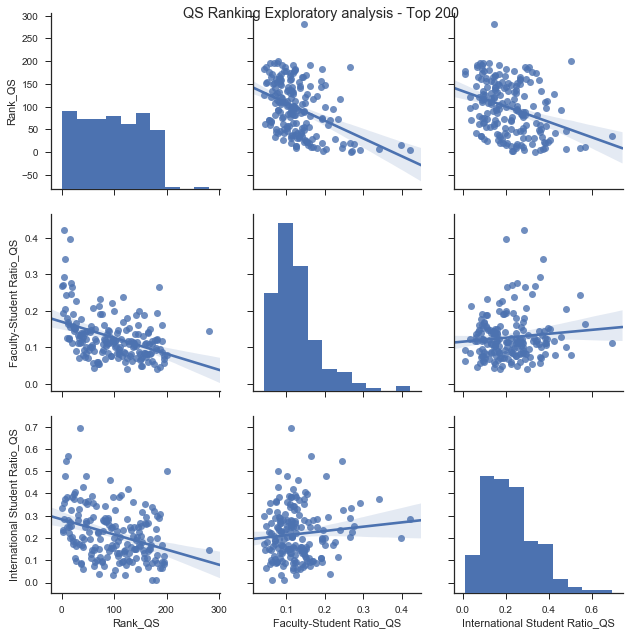

,Rank_QS,Faculty-Student Ratio_QS,International Student Ratio_QS
Rank_QS,1.000000,-0.412856,-0.338580
Faculty-Student Ratio_QS,-0.412856,1.000000,0.101946
International Student Ratio_QS,-0.338580,0.101946,1.000000


In [35]:
# Represent the QS data with scatter plots 
# TM1 represents QS rankings and TM2 represents THE rankings
TM1.dropna(axis=0,inplace=True)

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

sns.set(style="ticks")

sns.pairplot(TM1, size=3, kind="reg")
sns.plt.suptitle('QS Ranking Exploratory analysis - Top 200')

plt.show()
TM1.corr()

For the QS University ranking, the correlation between variables is again weak. A modest correlation can be observed for Rank_QS against Faculty-Student Ratio_QS. A slightly weaker correlation exists between Rank_QS and International Student Ratio_QS.

How can we improve our approach? Let's try to look at the top 50 of the ranking. 

In [36]:
# Take the top 50 ranked universities
# TM1 represents QS rankings and TM2 represents THE rankings
qs_50 = TM1.iloc[0:50, :]
the_50 = TM2.iloc[0:50, :]

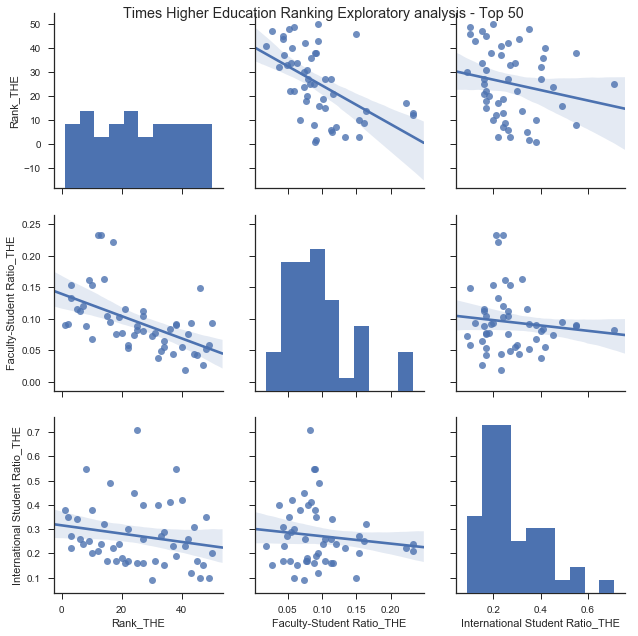

,Rank_THE,Faculty-Student Ratio_THE,International Student Ratio_THE
Rank_THE,1.000000,-0.532445,-0.192548
Faculty-Student Ratio_THE,-0.532445,1.000000,-0.113837
International Student Ratio_THE,-0.192548,-0.113837,1.000000


In [37]:
# Represent the THE (Times Higher Education) data with scatter plots 
# TM1 represents QS rankings and TM2 represents THE rankings
sns.set(style="ticks")

sns.pairplot(the_50, size=3, kind="reg")
sns.plt.suptitle('Times Higher Education Ranking Exploratory analysis - Top 50')

plt.show()
the_50.corr()

The top 50 schools of Times higher education results in a modest negative correlation between the Faculty-Student Ratio_THE and the Rank_THE. Thus, as the faculty-student ratio increases for a university in the THE data, the ranking becomes better (lower) as well.

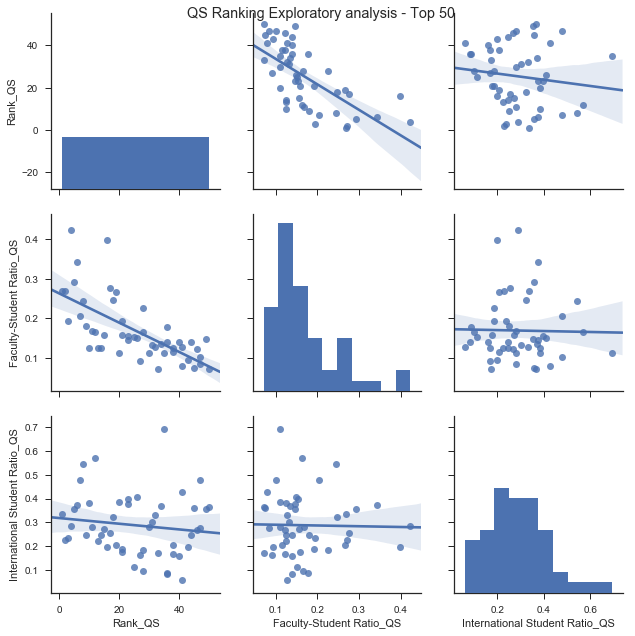

,Rank_QS,Faculty-Student Ratio_QS,International Student Ratio_QS
Rank_QS,1.000000,-0.668136,-0.131855
Faculty-Student Ratio_QS,-0.668136,1.000000,-0.019387
International Student Ratio_QS,-0.131855,-0.019387,1.000000


In [38]:
# Represent the QS data with scatter plots 
# TM1 represents QS rankings and TM2 represents THE rankings
import seaborn as sns
sns.set(style="ticks")

sns.pairplot(qs_50, size=3, kind="reg")
sns.plt.suptitle('QS Ranking Exploratory analysis - Top 50')

plt.show()
qs_50.corr()

The top 50 schools of QS ranking education results in a modest to fairly strong correlation between the Faculty-Student Ratio_QS and the Rank_QS. Thus, as the faculty-student ratio increases for a university in the QS data, the ranking becomes better (lower), similar to the THE data.

### Conclusion:

Together this data indicates that the rank and the faculty-student ratio are moderately correlated. By increasing faculty to student ratio, there might be an improvement in education and pedagogy, research quality, recommendations to jobs, and citations through better research. As a result, this might be the related to the better ranks as well. However, the international student ratio does not seem determinant enough to find a strong correlation.

## Question 5
Can you find the best university taking in consideration both rankings? Explain your approach.

In [39]:
# Calculate the average rank from both datasets for each university
merged_df['Average Rank'] = (merged_df['Rank_QS'] + merged_df['Rank_THE'])/2.0

# Find the minimum average rank to indicate best university
merged_df.loc[[merged_df['Average Rank'].argmin()]]

,University,Rank_QS,Country,Region,Faculty-Student Ratio_QS,International Student Ratio_QS,Rank_THE,Faculty-Student Ratio_THE,International Student Ratio_THE,Average Rank
1,Stanford University,2.0,United States,North America,0.26987,0.227422,3.0,0.133333,0.22,2.5


#### Explanation
In order to find the best university taking into consideration both rankings, we first calulated the average rank of each university. Then, we found the minimum of the averages to indicate the best university. In this case, 'Stanford University' has the lowest average rank.